<a href="https://www.kaggle.com/code/mohamedboghdadyy/102-category-flower-dataset-using-convformer-s18?scriptVersionId=191464161" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install some needed library


In [1]:
!pip install --upgrade livelossplot 

# 1- Import libraries

In [3]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets 
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import numpy as np
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import shutil
import tarfile
from scipy.io import loadmat
import timm
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchvision


# Preprocessing the data

## 1- uncompress the data

In [4]:
# Extract tar file
tar = tarfile.open('/kaggle/input/flower/102flowers.tgz', 'r:gz')
tar.extractall()
tar.close()

## load the labels and the images

In [100]:
# Load data
data = loadmat('/kaggle/input/labels/imagelabels.mat')
label = data['labels'].tolist()[0]


In [105]:
# Retrieve all image paths
image_paths = glob("/kaggle/working/jpg/*.jpg")

# Sort paths based on numerical order in the filenames
image_paths.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))


In [106]:
df = pd.DataFrame({'data': image_paths, 'labels': label})


In [109]:
df.head()

data  labels
0  /kaggle/working/jpg/image_00001.jpg      77
1  /kaggle/working/jpg/image_00002.jpg      77
2  /kaggle/working/jpg/image_00003.jpg      77
3  /kaggle/working/jpg/image_00004.jpg      77
4  /kaggle/working/jpg/image_00005.jpg      77

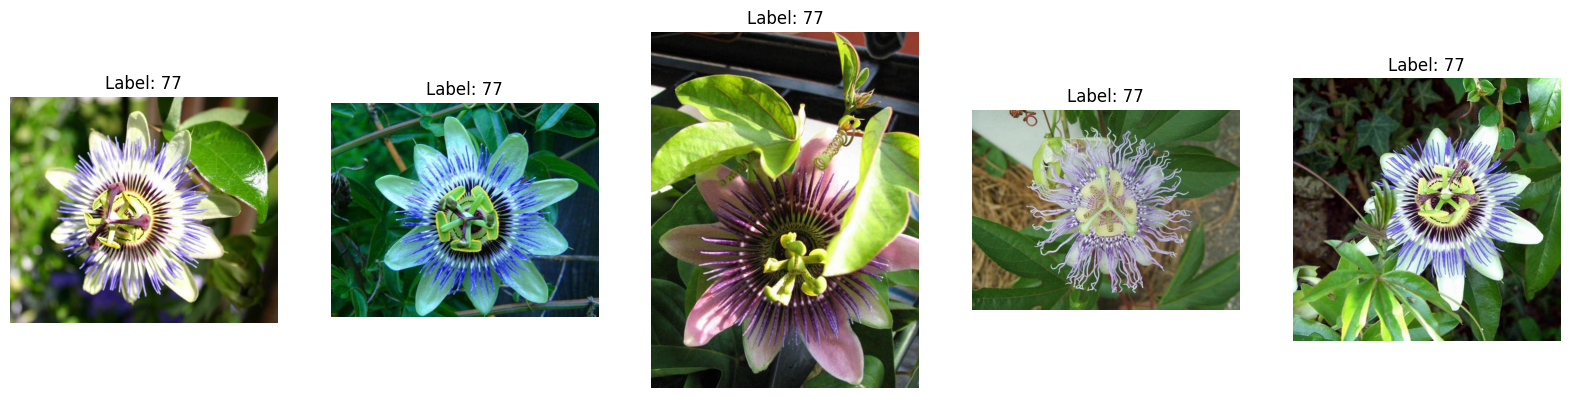

In [110]:

# Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    # Load and display the image
    img_path = df['data'].iloc[i]
    img = Image.open(img_path)
    
    ax.imshow(img)
    ax.set_title(f"Label: {df['labels'].iloc[i]}")
    ax.axis("off")

plt.show()

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    df['data'], df['labels'], test_size=0.20, random_state=42)

In [113]:
y_train, y_test=y_train-1, y_test-1

In [114]:
X_train

3783    /kaggle/working/jpg/image_03784.jpg
2110    /kaggle/working/jpg/image_02111.jpg
2002    /kaggle/working/jpg/image_02003.jpg
3047    /kaggle/working/jpg/image_03048.jpg
418     /kaggle/working/jpg/image_00419.jpg
                       ...                 
5226    /kaggle/working/jpg/image_05227.jpg
5390    /kaggle/working/jpg/image_05391.jpg
860     /kaggle/working/jpg/image_00861.jpg
7603    /kaggle/working/jpg/image_07604.jpg
7270    /kaggle/working/jpg/image_07271.jpg
Name: data, Length: 6551, dtype: object

# Load the data and prepare it for training
the data is loaded, transformed and agumented. the convenient agumentaions only are applied to avoid black images

In [115]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.tolist()  # Convert to list
        self.labels = labels.tolist()  # Convert to list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image,label


In [116]:
# Set the root directory where the dataset will be downloaded
root = '/kaggle/working/'

# Define the transformations to be applied to the images
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224, padding_mode="reflect", pad_if_needed=True),
        transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10),
        transforms.RandomHorizontalFlip(0.5),
        # Color augmentations
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
}


train_dataset = CustomDataset(X_train,y_train, transform=data_transforms['train'])
test_dataset = CustomDataset(X_test,y_test, transform=data_transforms['test'])


# Create data loaders for train, validation, and test datasets
batch_size = 32
data_loaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
}


In [117]:
image,label=next(iter(data_loaders['train']))


In [118]:
image.shape

torch.Size([32, 3, 224, 224])

## class names
I used names provided by tensorflow just to make it readable

In [119]:
names = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "english marigold",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia?",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen",
    "watercress",
    "canna lily",
    "hippeastrum",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
]

# Visualize some images

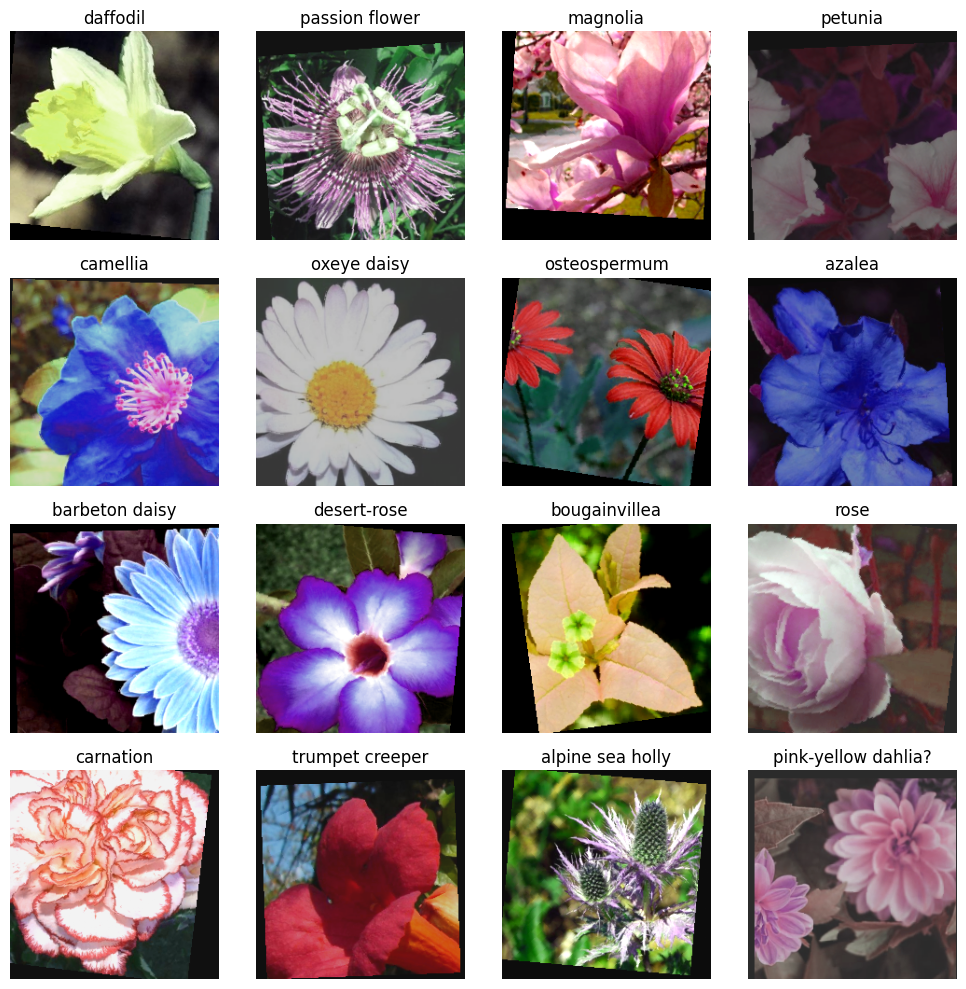

In [120]:
# Get the first batch of images
dataiter = next(iter(data_loaders['train']))
images, labels = dataiter

# Preprocess images (if necessary, e.g., normalize to [0, 1])
images = images / 2 + 0.5  

# Create a grid of images
grid = torchvision.utils.make_grid(images)
grid = grid.numpy().transpose((1, 2, 0))

# Create a figure and axes
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each image with its label as the title
for ax, img, label in zip(axes, images, labels):
    ax.imshow(img.permute(1, 2, 0))  # Permute channels for matplotlib
    ax.set_title(names[label])  # Assuming labels are class indices
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

# Loading the model

 the model is loaded 

In [150]:
model = timm.create_model("convformer_s18", pretrained=True,num_classes=102)


In [151]:
frozen_parameters = []

for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.head.parameters():
    p.requires_grad = True



Froze 242 groups of parameters


# Training
  

In [139]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [140]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define the number of epochs
num_epochs = 10

# Define directories to save model
model_save_path = 'best_model.pth'
best_accuracy = 0.0


In [125]:
!pip install torchmetrics

In [129]:
 import  torchmetrics 
    

In [141]:
accuracy_metric = torchmetrics.Accuracy(num_classes=102,task="multiclass").to(device)
precision_metric = torchmetrics.Precision(num_classes=102,task="multiclass").to(device)
recall_metric = torchmetrics.Recall(num_classes=102,task="multiclass").to(device)

# Define the number of epochs
num_epochs = 100

In [142]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        _, predicted = torch.max(outputs, 1)
        accuracy_metric.update(predicted, labels)
        precision_metric.update(predicted, labels)
        recall_metric.update(predicted, labels)
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_metric.compute() * 100
    precision = precision_metric.compute() * 100
    recall = recall_metric.compute() * 100
    return epoch_loss, accuracy, precision, recall

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate metrics
            _, predicted = torch.max(outputs, 1)
            accuracy_metric.update(predicted, labels)
            precision_metric.update(predicted, labels)
            recall_metric.update(predicted, labels)
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_metric.compute() * 100
    precision = precision_metric.compute() * 100
    recall = recall_metric.compute() * 100
    return epoch_loss, accuracy, precision, recall



In [143]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy, train_precision, train_recall = train_one_epoch(model, data_loaders['train'], criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.2f}%, Train Recall: {train_recall:.2f}%")
    
    # Evaluation
    test_loss, test_accuracy, test_precision, test_recall = evaluate(model, data_loaders['test'], criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.2f}%, Test Recall: {test_recall:.2f}%")
    
    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved best model with accuracy: {best_accuracy:.2f}%")

print(f"Training complete. Best test accuracy: {best_accuracy:.2f}%")

Epoch 1/100


Train Loss: 2.1028, Train Accuracy: 49.61%, Train Precision: 49.61%, Train Recall: 49.61%


Test Loss: 1.0066, Test Accuracy: 71.49%, Test Precision: 71.49%, Test Recall: 71.49%
Saved best model with accuracy: 71.49%
Epoch 2/100


Train Loss: 0.8037, Train Accuracy: 77.26%, Train Precision: 77.26%, Train Recall: 77.26%


Test Loss: 0.6740, Test Accuracy: 80.16%, Test Precision: 80.16%, Test Recall: 80.16%
Saved best model with accuracy: 80.16%
Epoch 3/100


Train Loss: 0.5976, Train Accuracy: 82.41%, Train Precision: 82.41%, Train Recall: 82.41%


Test Loss: 0.5868, Test Accuracy: 83.94%, Test Precision: 83.94%, Test Recall: 83.94%
Saved best model with accuracy: 83.94%
Epoch 4/100


Train Loss: 0.4954, Train Accuracy: 85.44%, Train Precision: 85.44%, Train Recall: 85.44%


Test Loss: 0.5379, Test Accuracy: 83.82%, Test Precision: 83.82%, Test Recall: 83.82%
Epoch 5/100


Train Loss: 0.4243, Train Accuracy: 86.99%, Train Precision: 86.99%, Train Recall: 86.99%


Test Loss: 0.5506, Test Accuracy: 83.52%, Test Precision: 83.52%, Test Recall: 83.52%
Epoch 6/100


Train Loss: 0.4129, Train Accuracy: 87.56%, Train Precision: 87.56%, Train Recall: 87.56%


Test Loss: 0.4944, Test Accuracy: 83.94%, Test Precision: 83.94%, Test Recall: 83.94%
Epoch 7/100


Train Loss: 0.3458, Train Accuracy: 89.44%, Train Precision: 89.44%, Train Recall: 89.44%


Test Loss: 0.4987, Test Accuracy: 85.16%, Test Precision: 85.16%, Test Recall: 85.16%
Saved best model with accuracy: 85.16%
Epoch 8/100


Train Loss: 0.3358, Train Accuracy: 89.36%, Train Precision: 89.36%, Train Recall: 89.36%


Test Loss: 0.4840, Test Accuracy: 86.14%, Test Precision: 86.14%, Test Recall: 86.14%
Saved best model with accuracy: 86.14%
Epoch 9/100


Train Loss: 0.3034, Train Accuracy: 90.73%, Train Precision: 90.73%, Train Recall: 90.73%


Test Loss: 0.4051, Test Accuracy: 87.97%, Test Precision: 87.97%, Test Recall: 87.97%
Saved best model with accuracy: 87.97%
Epoch 10/100


Train Loss: 0.2955, Train Accuracy: 90.60%, Train Precision: 90.60%, Train Recall: 90.60%


Test Loss: 0.4509, Test Accuracy: 87.61%, Test Precision: 87.61%, Test Recall: 87.61%
Epoch 11/100


Train Loss: 0.2685, Train Accuracy: 91.76%, Train Precision: 91.76%, Train Recall: 91.76%


Test Loss: 0.4248, Test Accuracy: 87.85%, Test Precision: 87.85%, Test Recall: 87.85%
Epoch 12/100


Train Loss: 0.2721, Train Accuracy: 91.59%, Train Precision: 91.59%, Train Recall: 91.59%


Test Loss: 0.3756, Test Accuracy: 89.38%, Test Precision: 89.38%, Test Recall: 89.38%
Saved best model with accuracy: 89.38%
Epoch 13/100


Train Loss: 0.2700, Train Accuracy: 91.73%, Train Precision: 91.73%, Train Recall: 91.73%


Test Loss: 0.3806, Test Accuracy: 89.07%, Test Precision: 89.07%, Test Recall: 89.07%
Epoch 14/100


Train Loss: 0.2380, Train Accuracy: 92.60%, Train Precision: 92.60%, Train Recall: 92.60%


Test Loss: 0.3961, Test Accuracy: 88.46%, Test Precision: 88.46%, Test Recall: 88.46%
Epoch 15/100


Train Loss: 0.2081, Train Accuracy: 93.45%, Train Precision: 93.45%, Train Recall: 93.45%


Test Loss: 0.4069, Test Accuracy: 88.28%, Test Precision: 88.28%, Test Recall: 88.28%
Epoch 16/100


Train Loss: 0.2356, Train Accuracy: 92.61%, Train Precision: 92.61%, Train Recall: 92.61%


Test Loss: 0.3749, Test Accuracy: 89.50%, Test Precision: 89.50%, Test Recall: 89.50%
Saved best model with accuracy: 89.50%
Epoch 17/100


Train Loss: 0.2154, Train Accuracy: 92.83%, Train Precision: 92.83%, Train Recall: 92.83%


Test Loss: 0.3935, Test Accuracy: 88.34%, Test Precision: 88.34%, Test Recall: 88.34%
Epoch 18/100


Train Loss: 0.2139, Train Accuracy: 93.25%, Train Precision: 93.25%, Train Recall: 93.25%


Test Loss: 0.4162, Test Accuracy: 87.36%, Test Precision: 87.36%, Test Recall: 87.36%
Epoch 19/100


Train Loss: 0.2124, Train Accuracy: 93.25%, Train Precision: 93.25%, Train Recall: 93.25%


Test Loss: 0.3539, Test Accuracy: 89.80%, Test Precision: 89.80%, Test Recall: 89.80%
Saved best model with accuracy: 89.80%
Epoch 20/100


Train Loss: 0.1838, Train Accuracy: 94.15%, Train Precision: 94.15%, Train Recall: 94.15%


Test Loss: 0.3361, Test Accuracy: 89.56%, Test Precision: 89.56%, Test Recall: 89.56%
Epoch 21/100


Train Loss: 0.2006, Train Accuracy: 93.85%, Train Precision: 93.85%, Train Recall: 93.85%


Test Loss: 0.4071, Test Accuracy: 88.58%, Test Precision: 88.58%, Test Recall: 88.58%
Epoch 22/100


Train Loss: 0.1931, Train Accuracy: 93.51%, Train Precision: 93.51%, Train Recall: 93.51%


Test Loss: 0.3414, Test Accuracy: 89.13%, Test Precision: 89.13%, Test Recall: 89.13%
Epoch 23/100


Train Loss: 0.1799, Train Accuracy: 94.28%, Train Precision: 94.28%, Train Recall: 94.28%


Test Loss: 0.4042, Test Accuracy: 89.80%, Test Precision: 89.80%, Test Recall: 89.80%
Epoch 24/100


Train Loss: 0.1709, Train Accuracy: 94.37%, Train Precision: 94.37%, Train Recall: 94.37%


Test Loss: 0.4081, Test Accuracy: 89.01%, Test Precision: 89.01%, Test Recall: 89.01%
Epoch 25/100


Train Loss: 0.1717, Train Accuracy: 94.70%, Train Precision: 94.70%, Train Recall: 94.70%


Test Loss: 0.3777, Test Accuracy: 88.83%, Test Precision: 88.83%, Test Recall: 88.83%
Epoch 26/100


Train Loss: 0.1709, Train Accuracy: 94.57%, Train Precision: 94.57%, Train Recall: 94.57%


Test Loss: 0.3722, Test Accuracy: 89.68%, Test Precision: 89.68%, Test Recall: 89.68%
Epoch 27/100


Train Loss: 0.1641, Train Accuracy: 94.78%, Train Precision: 94.78%, Train Recall: 94.78%


Test Loss: 0.3276, Test Accuracy: 91.15%, Test Precision: 91.15%, Test Recall: 91.15%
Saved best model with accuracy: 91.15%
Epoch 28/100


Train Loss: 0.1625, Train Accuracy: 94.52%, Train Precision: 94.52%, Train Recall: 94.52%


Test Loss: 0.3396, Test Accuracy: 90.78%, Test Precision: 90.78%, Test Recall: 90.78%
Epoch 29/100


Train Loss: 0.1620, Train Accuracy: 95.22%, Train Precision: 95.22%, Train Recall: 95.22%


Test Loss: 0.3548, Test Accuracy: 89.87%, Test Precision: 89.87%, Test Recall: 89.87%
Epoch 30/100


Train Loss: 0.1479, Train Accuracy: 94.98%, Train Precision: 94.98%, Train Recall: 94.98%


Test Loss: 0.3588, Test Accuracy: 90.35%, Test Precision: 90.35%, Test Recall: 90.35%
Epoch 31/100


Train Loss: 0.1436, Train Accuracy: 95.18%, Train Precision: 95.18%, Train Recall: 95.18%


Test Loss: 0.3975, Test Accuracy: 89.19%, Test Precision: 89.19%, Test Recall: 89.19%
Epoch 32/100


Train Loss: 0.1334, Train Accuracy: 95.62%, Train Precision: 95.62%, Train Recall: 95.62%


Test Loss: 0.3500, Test Accuracy: 90.60%, Test Precision: 90.60%, Test Recall: 90.60%
Epoch 33/100


Train Loss: 0.1287, Train Accuracy: 95.83%, Train Precision: 95.83%, Train Recall: 95.83%


Test Loss: 0.4259, Test Accuracy: 88.28%, Test Precision: 88.28%, Test Recall: 88.28%
Epoch 34/100


Train Loss: 0.1421, Train Accuracy: 95.47%, Train Precision: 95.47%, Train Recall: 95.47%


Test Loss: 0.3994, Test Accuracy: 90.11%, Test Precision: 90.11%, Test Recall: 90.11%
Epoch 35/100


Train Loss: 0.1287, Train Accuracy: 95.83%, Train Precision: 95.83%, Train Recall: 95.83%


Test Loss: 0.3694, Test Accuracy: 90.42%, Test Precision: 90.42%, Test Recall: 90.42%
Epoch 36/100


Train Loss: 0.1361, Train Accuracy: 95.66%, Train Precision: 95.66%, Train Recall: 95.66%


Test Loss: 0.3682, Test Accuracy: 89.80%, Test Precision: 89.80%, Test Recall: 89.80%
Epoch 37/100


Train Loss: 0.1308, Train Accuracy: 95.77%, Train Precision: 95.77%, Train Recall: 95.77%


Test Loss: 0.3303, Test Accuracy: 90.23%, Test Precision: 90.23%, Test Recall: 90.23%
Epoch 38/100


Train Loss: 0.1309, Train Accuracy: 95.86%, Train Precision: 95.86%, Train Recall: 95.86%


Test Loss: 0.3050, Test Accuracy: 91.70%, Test Precision: 91.70%, Test Recall: 91.70%
Saved best model with accuracy: 91.70%
Epoch 39/100


Train Loss: 0.1173, Train Accuracy: 96.38%, Train Precision: 96.38%, Train Recall: 96.38%


Test Loss: 0.3084, Test Accuracy: 91.21%, Test Precision: 91.21%, Test Recall: 91.21%
Epoch 40/100


Train Loss: 0.1305, Train Accuracy: 95.82%, Train Precision: 95.82%, Train Recall: 95.82%


Test Loss: 0.3759, Test Accuracy: 89.44%, Test Precision: 89.44%, Test Recall: 89.44%
Epoch 41/100


Train Loss: 0.1248, Train Accuracy: 95.68%, Train Precision: 95.68%, Train Recall: 95.68%


Test Loss: 0.3930, Test Accuracy: 89.80%, Test Precision: 89.80%, Test Recall: 89.80%
Epoch 42/100


Train Loss: 0.1199, Train Accuracy: 96.12%, Train Precision: 96.12%, Train Recall: 96.12%


Test Loss: 0.3257, Test Accuracy: 91.03%, Test Precision: 91.03%, Test Recall: 91.03%
Epoch 43/100


Train Loss: 0.1266, Train Accuracy: 95.82%, Train Precision: 95.82%, Train Recall: 95.82%


Test Loss: 0.3204, Test Accuracy: 91.33%, Test Precision: 91.33%, Test Recall: 91.33%
Epoch 44/100


Train Loss: 0.0943, Train Accuracy: 96.90%, Train Precision: 96.90%, Train Recall: 96.90%


Test Loss: 0.3817, Test Accuracy: 89.87%, Test Precision: 89.87%, Test Recall: 89.87%
Epoch 45/100


Train Loss: 0.1096, Train Accuracy: 96.43%, Train Precision: 96.43%, Train Recall: 96.43%


Test Loss: 0.3437, Test Accuracy: 91.21%, Test Precision: 91.21%, Test Recall: 91.21%
Epoch 46/100


Train Loss: 0.1079, Train Accuracy: 96.43%, Train Precision: 96.43%, Train Recall: 96.43%


Test Loss: 0.3361, Test Accuracy: 90.96%, Test Precision: 90.96%, Test Recall: 90.96%
Epoch 47/100


Train Loss: 0.0992, Train Accuracy: 96.98%, Train Precision: 96.98%, Train Recall: 96.98%


Test Loss: 0.3135, Test Accuracy: 91.39%, Test Precision: 91.39%, Test Recall: 91.39%
Epoch 48/100


Train Loss: 0.1005, Train Accuracy: 96.76%, Train Precision: 96.76%, Train Recall: 96.76%


Test Loss: 0.3338, Test Accuracy: 91.27%, Test Precision: 91.27%, Test Recall: 91.27%
Epoch 49/100


Train Loss: 0.1071, Train Accuracy: 96.55%, Train Precision: 96.55%, Train Recall: 96.55%


Test Loss: 0.3213, Test Accuracy: 91.58%, Test Precision: 91.58%, Test Recall: 91.58%
Epoch 50/100


Train Loss: 0.0901, Train Accuracy: 96.98%, Train Precision: 96.98%, Train Recall: 96.98%


Test Loss: 0.3755, Test Accuracy: 90.23%, Test Precision: 90.23%, Test Recall: 90.23%
Epoch 51/100


Train Loss: 0.0992, Train Accuracy: 96.64%, Train Precision: 96.64%, Train Recall: 96.64%


Test Loss: 0.3307, Test Accuracy: 91.03%, Test Precision: 91.03%, Test Recall: 91.03%
Epoch 52/100


Train Loss: 0.0972, Train Accuracy: 96.78%, Train Precision: 96.78%, Train Recall: 96.78%


Test Loss: 0.2915, Test Accuracy: 91.82%, Test Precision: 91.82%, Test Recall: 91.82%
Saved best model with accuracy: 91.82%
Epoch 53/100


Train Loss: 0.0924, Train Accuracy: 97.11%, Train Precision: 97.11%, Train Recall: 97.11%


Test Loss: 0.3323, Test Accuracy: 91.33%, Test Precision: 91.33%, Test Recall: 91.33%
Epoch 54/100


Train Loss: 0.0975, Train Accuracy: 96.87%, Train Precision: 96.87%, Train Recall: 96.87%


Test Loss: 0.3430, Test Accuracy: 90.90%, Test Precision: 90.90%, Test Recall: 90.90%
Epoch 55/100


Train Loss: 0.0927, Train Accuracy: 97.15%, Train Precision: 97.15%, Train Recall: 97.15%


Test Loss: 0.3558, Test Accuracy: 91.09%, Test Precision: 91.09%, Test Recall: 91.09%
Epoch 57/100


Train Loss: 0.1026, Train Accuracy: 96.84%, Train Precision: 96.84%, Train Recall: 96.84%


Test Loss: 0.3296, Test Accuracy: 92.06%, Test Precision: 92.06%, Test Recall: 92.06%
Saved best model with accuracy: 92.06%
Epoch 58/100


Train Loss: 0.1058, Train Accuracy: 96.73%, Train Precision: 96.73%, Train Recall: 96.73%


Test Loss: 0.3591, Test Accuracy: 90.78%, Test Precision: 90.78%, Test Recall: 90.78%
Epoch 59/100


Train Loss: 0.0990, Train Accuracy: 96.93%, Train Precision: 96.93%, Train Recall: 96.93%


Test Loss: 0.3157, Test Accuracy: 92.00%, Test Precision: 92.00%, Test Recall: 92.00%
Epoch 60/100


Train Loss: 0.0965, Train Accuracy: 96.69%, Train Precision: 96.69%, Train Recall: 96.69%


Test Loss: 0.3372, Test Accuracy: 91.70%, Test Precision: 91.70%, Test Recall: 91.70%
Epoch 61/100


Train Loss: 0.1000, Train Accuracy: 96.96%, Train Precision: 96.96%, Train Recall: 96.96%


Test Loss: 0.3405, Test Accuracy: 91.82%, Test Precision: 91.82%, Test Recall: 91.82%
Epoch 62/100


Train Loss: 0.0918, Train Accuracy: 96.96%, Train Precision: 96.96%, Train Recall: 96.96%


Test Loss: 0.3057, Test Accuracy: 92.25%, Test Precision: 92.25%, Test Recall: 92.25%
Saved best model with accuracy: 92.25%
Epoch 63/100


Train Loss: 0.0923, Train Accuracy: 97.15%, Train Precision: 97.15%, Train Recall: 97.15%


Test Loss: 0.3113, Test Accuracy: 92.06%, Test Precision: 92.06%, Test Recall: 92.06%
Epoch 64/100


Train Loss: 0.0905, Train Accuracy: 96.99%, Train Precision: 96.99%, Train Recall: 96.99%


Test Loss: 0.3796, Test Accuracy: 90.29%, Test Precision: 90.29%, Test Recall: 90.29%
Epoch 65/100


Train Loss: 0.0921, Train Accuracy: 97.07%, Train Precision: 97.07%, Train Recall: 97.07%


Test Loss: 0.3267, Test Accuracy: 91.27%, Test Precision: 91.27%, Test Recall: 91.27%
Epoch 66/100


Train Loss: 0.0809, Train Accuracy: 97.34%, Train Precision: 97.34%, Train Recall: 97.34%


Test Loss: 0.3987, Test Accuracy: 90.72%, Test Precision: 90.72%, Test Recall: 90.72%
Epoch 67/100


Train Loss: 0.0820, Train Accuracy: 97.25%, Train Precision: 97.25%, Train Recall: 97.25%


Test Loss: 0.3234, Test Accuracy: 91.33%, Test Precision: 91.33%, Test Recall: 91.33%
Epoch 68/100


Train Loss: 0.0738, Train Accuracy: 97.60%, Train Precision: 97.60%, Train Recall: 97.60%


Test Loss: 0.3632, Test Accuracy: 90.29%, Test Precision: 90.29%, Test Recall: 90.29%
Epoch 69/100


Train Loss: 0.0834, Train Accuracy: 97.36%, Train Precision: 97.36%, Train Recall: 97.36%


Test Loss: 0.3532, Test Accuracy: 90.90%, Test Precision: 90.90%, Test Recall: 90.90%
Epoch 70/100


Train Loss: 0.0822, Train Accuracy: 97.42%, Train Precision: 97.42%, Train Recall: 97.42%


Test Loss: 0.3403, Test Accuracy: 91.39%, Test Precision: 91.39%, Test Recall: 91.39%
Epoch 71/100


Train Loss: 0.0837, Train Accuracy: 97.24%, Train Precision: 97.24%, Train Recall: 97.24%


Test Loss: 0.3406, Test Accuracy: 90.72%, Test Precision: 90.72%, Test Recall: 90.72%
Epoch 72/100


Train Loss: 0.0865, Train Accuracy: 97.11%, Train Precision: 97.11%, Train Recall: 97.11%


Test Loss: 0.3255, Test Accuracy: 91.51%, Test Precision: 91.51%, Test Recall: 91.51%
Epoch 73/100


Train Loss: 0.0850, Train Accuracy: 97.40%, Train Precision: 97.40%, Train Recall: 97.40%


Test Loss: 0.3554, Test Accuracy: 91.09%, Test Precision: 91.09%, Test Recall: 91.09%
Epoch 74/100


Train Loss: 0.0847, Train Accuracy: 97.27%, Train Precision: 97.27%, Train Recall: 97.27%


Test Loss: 0.3569, Test Accuracy: 91.15%, Test Precision: 91.15%, Test Recall: 91.15%
Epoch 75/100


Train Loss: 0.0905, Train Accuracy: 97.25%, Train Precision: 97.25%, Train Recall: 97.25%


Test Loss: 0.3487, Test Accuracy: 90.78%, Test Precision: 90.78%, Test Recall: 90.78%
Epoch 76/100


Train Loss: 0.0909, Train Accuracy: 97.21%, Train Precision: 97.21%, Train Recall: 97.21%


Test Loss: 0.3734, Test Accuracy: 90.90%, Test Precision: 90.90%, Test Recall: 90.90%
Epoch 77/100


Train Loss: 0.0888, Train Accuracy: 97.05%, Train Precision: 97.05%, Train Recall: 97.05%


Test Loss: 0.3679, Test Accuracy: 90.84%, Test Precision: 90.84%, Test Recall: 90.84%
Epoch 78/100


Train Loss: 0.0812, Train Accuracy: 97.48%, Train Precision: 97.48%, Train Recall: 97.48%


Test Loss: 0.3370, Test Accuracy: 91.58%, Test Precision: 91.58%, Test Recall: 91.58%
Epoch 79/100


Train Loss: 0.0670, Train Accuracy: 97.74%, Train Precision: 97.74%, Train Recall: 97.74%


Test Loss: 0.3240, Test Accuracy: 91.27%, Test Precision: 91.27%, Test Recall: 91.27%
Epoch 80/100


Train Loss: 0.0718, Train Accuracy: 97.95%, Train Precision: 97.95%, Train Recall: 97.95%


Test Loss: 0.4164, Test Accuracy: 90.35%, Test Precision: 90.35%, Test Recall: 90.35%
Epoch 81/100


Train Loss: 0.0721, Train Accuracy: 97.59%, Train Precision: 97.59%, Train Recall: 97.59%


Test Loss: 0.3720, Test Accuracy: 91.51%, Test Precision: 91.51%, Test Recall: 91.51%
Epoch 82/100


Train Loss: 0.0969, Train Accuracy: 96.93%, Train Precision: 96.93%, Train Recall: 96.93%


Test Loss: 0.3496, Test Accuracy: 90.84%, Test Precision: 90.84%, Test Recall: 90.84%
Epoch 83/100


Train Loss: 0.0866, Train Accuracy: 97.18%, Train Precision: 97.18%, Train Recall: 97.18%


Test Loss: 0.3452, Test Accuracy: 92.00%, Test Precision: 92.00%, Test Recall: 92.00%
Epoch 84/100


Train Loss: 0.0713, Train Accuracy: 97.63%, Train Precision: 97.63%, Train Recall: 97.63%


Test Loss: 0.3226, Test Accuracy: 92.49%, Test Precision: 92.49%, Test Recall: 92.49%
Saved best model with accuracy: 92.49%
Epoch 85/100


Train Loss: 0.0877, Train Accuracy: 97.27%, Train Precision: 97.27%, Train Recall: 97.27%


Test Loss: 0.3566, Test Accuracy: 91.64%, Test Precision: 91.64%, Test Recall: 91.64%
Epoch 86/100


Train Loss: 0.0613, Train Accuracy: 97.83%, Train Precision: 97.83%, Train Recall: 97.83%


Test Loss: 0.3771, Test Accuracy: 91.82%, Test Precision: 91.82%, Test Recall: 91.82%
Epoch 87/100


Train Loss: 0.0832, Train Accuracy: 97.08%, Train Precision: 97.08%, Train Recall: 97.08%


Test Loss: 0.3643, Test Accuracy: 91.88%, Test Precision: 91.88%, Test Recall: 91.88%
Epoch 88/100


Train Loss: 0.0847, Train Accuracy: 97.36%, Train Precision: 97.36%, Train Recall: 97.36%


Test Loss: 0.3416, Test Accuracy: 91.88%, Test Precision: 91.88%, Test Recall: 91.88%
Epoch 89/100


Train Loss: 0.0701, Train Accuracy: 97.68%, Train Precision: 97.68%, Train Recall: 97.68%


Test Loss: 0.3357, Test Accuracy: 91.76%, Test Precision: 91.76%, Test Recall: 91.76%
Epoch 90/100


Train Loss: 0.0695, Train Accuracy: 97.70%, Train Precision: 97.70%, Train Recall: 97.70%


Test Loss: 0.3587, Test Accuracy: 91.58%, Test Precision: 91.58%, Test Recall: 91.58%
Epoch 91/100


Train Loss: 0.0678, Train Accuracy: 97.88%, Train Precision: 97.88%, Train Recall: 97.88%


Test Loss: 0.2982, Test Accuracy: 92.92%, Test Precision: 92.92%, Test Recall: 92.92%
Saved best model with accuracy: 92.92%
Epoch 92/100


Train Loss: 0.0736, Train Accuracy: 97.65%, Train Precision: 97.65%, Train Recall: 97.65%


Test Loss: 0.3698, Test Accuracy: 91.21%, Test Precision: 91.21%, Test Recall: 91.21%
Epoch 93/100


Train Loss: 0.0627, Train Accuracy: 98.05%, Train Precision: 98.05%, Train Recall: 98.05%


Test Loss: 0.3375, Test Accuracy: 91.70%, Test Precision: 91.70%, Test Recall: 91.70%
Epoch 94/100


Train Loss: 0.0707, Train Accuracy: 97.74%, Train Precision: 97.74%, Train Recall: 97.74%


Test Loss: 0.3500, Test Accuracy: 92.12%, Test Precision: 92.12%, Test Recall: 92.12%
Epoch 95/100


Train Loss: 0.0793, Train Accuracy: 97.48%, Train Precision: 97.48%, Train Recall: 97.48%


Test Loss: 0.3506, Test Accuracy: 91.51%, Test Precision: 91.51%, Test Recall: 91.51%
Epoch 96/100


Train Loss: 0.0676, Train Accuracy: 97.86%, Train Precision: 97.86%, Train Recall: 97.86%


Test Loss: 0.3557, Test Accuracy: 91.39%, Test Precision: 91.39%, Test Recall: 91.39%
Epoch 97/100


Train Loss: 0.0684, Train Accuracy: 97.62%, Train Precision: 97.62%, Train Recall: 97.62%


Test Loss: 0.3833, Test Accuracy: 91.45%, Test Precision: 91.45%, Test Recall: 91.45%
Epoch 98/100


Train Loss: 0.0605, Train Accuracy: 98.03%, Train Precision: 98.03%, Train Recall: 98.03%


Test Loss: 0.3577, Test Accuracy: 91.45%, Test Precision: 91.45%, Test Recall: 91.45%
Epoch 99/100


Train Loss: 0.0685, Train Accuracy: 97.79%, Train Precision: 97.79%, Train Recall: 97.79%


Test Loss: 0.3510, Test Accuracy: 91.88%, Test Precision: 91.88%, Test Recall: 91.88%
Epoch 100/100


Train Loss: 0.0629, Train Accuracy: 98.05%, Train Precision: 98.05%, Train Recall: 98.05%


Test Loss: 0.4079, Test Accuracy: 90.48%, Test Precision: 90.48%, Test Recall: 90.48%
Training complete. Best test accuracy: 92.92%


# Make some predictions


In [152]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.to(device)
model.eval()

MetaFormer(
  (stem): Stem(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (norm): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): MetaFormerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): MetaFormerBlock(
          (norm1): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
          (token_mixer): SepConv(
            (pwconv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (act1): StarReLU(
              (relu): ReLU()
            )
            (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128, bias=False)
            (act2): Identity()
            (pwconv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (drop_path1): Identity()
          (layer_scale1): Identity()
          (res_scale1): Identity()
          (norm2): LayerNorm2dNoBias((64,), eps=1e-06, e

In [153]:
# Define a function to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

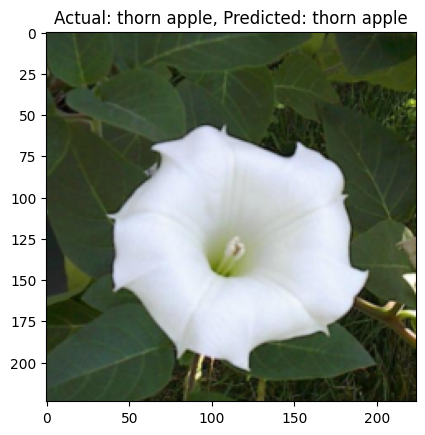

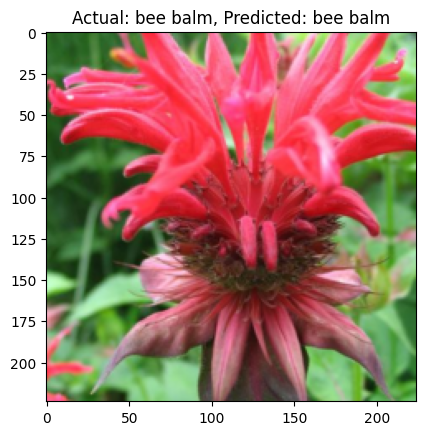

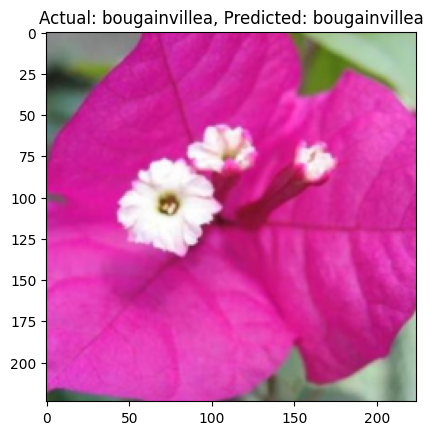

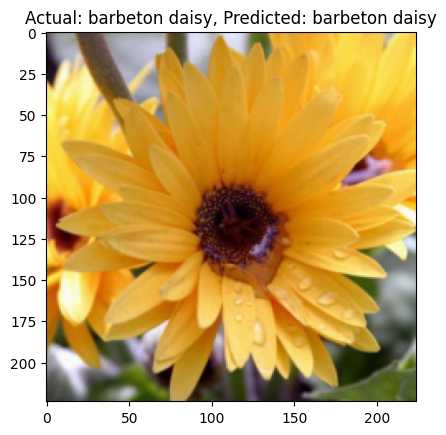

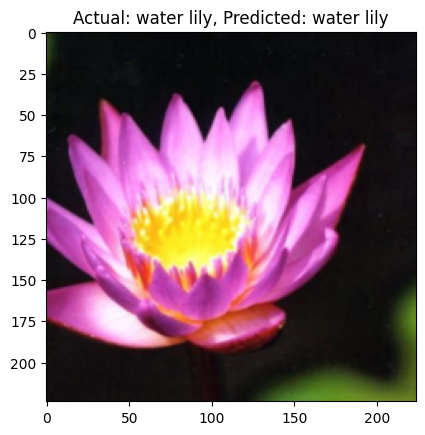

In [156]:
def predict_and_display(dataloader, model, device, num_images=5):
    class_names = [str(i) for i in range(102)]  # Adjust based on your dataset
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Show images and predictions
    for i in range(min(num_images, len(images))):
        img = images[i].cpu()
        label = labels[i].cpu().item()
        pred = preds[i].cpu().item()

        # Convert label and prediction to class names
        label_name = class_names[label]
        pred_name = class_names[pred]

        # Display the image with actual and predicted labels
        imshow(img, title=f"Actual: {names[int(label_name)]}, Predicted: {names[int(pred_name)]}")

# Predict and display results from the test dataloader
predict_and_display(data_loaders['test'], model, device)

# plot the confusion matrix

In [157]:
def plot_confusion_matrix(model, dataloader):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import confusion_matrix

    device = next(model.parameters()).device

    # Set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    gt = pd.Series(all_labels, name='Ground Truth')
    predicted = pd.Series(all_preds, name='Predicted')

    confusion_matrix_df = pd.crosstab(gt, predicted, rownames=['Actual'], colnames=['Predicted'])

    fig, sub = plt.subplots(figsize=(14, 12))
    with sns.plotting_context("notebook"):
        idx = (confusion_matrix_df == 0)
        confusion_matrix_df[idx] = np.nan
        sns.heatmap(confusion_matrix_df, annot=True, ax=sub, linewidths=0.5, linecolor='lightgray', cbar=False)

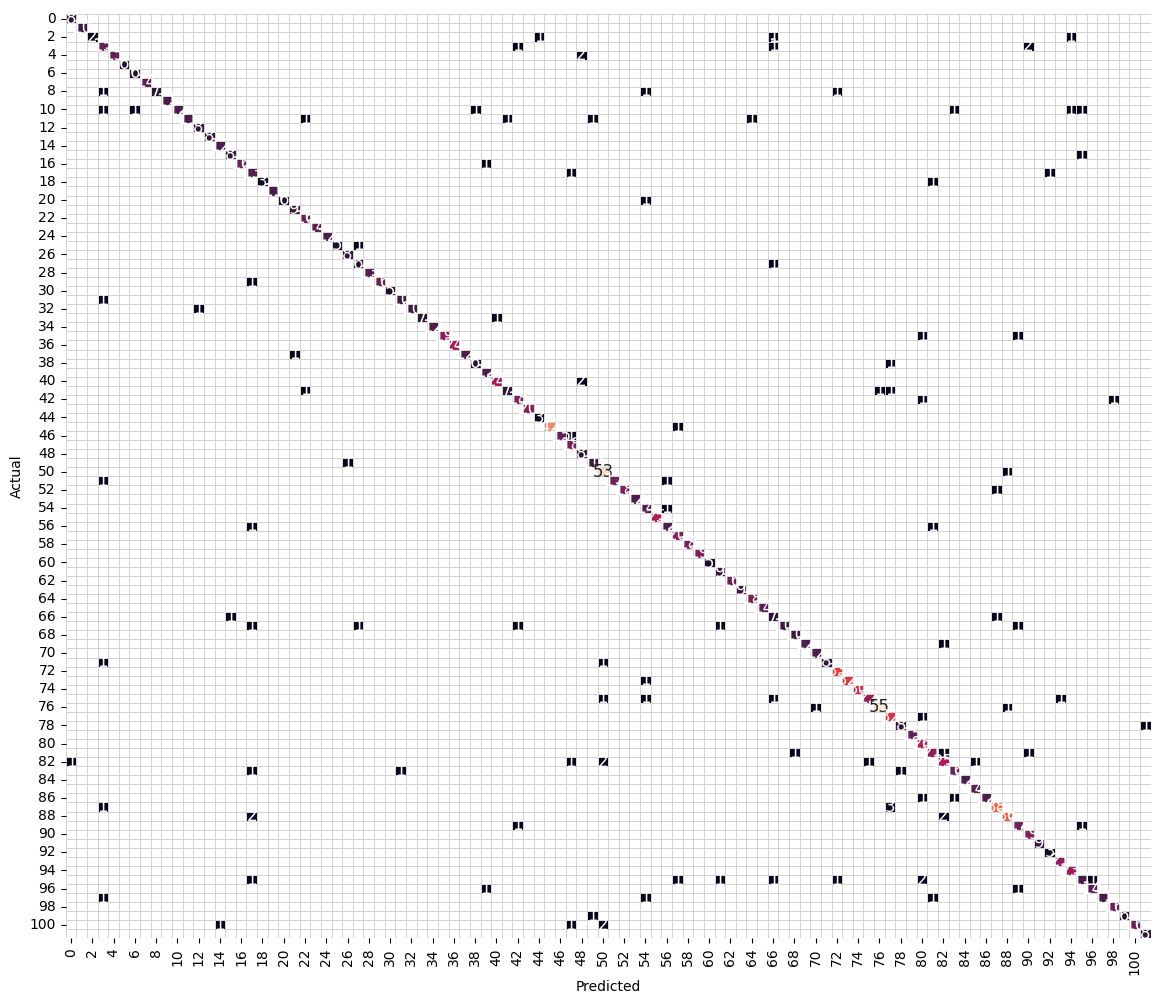

In [158]:
plot_confusion_matrix(model, data_loaders['test'])
